# Evaluate crop data for multiple datasets

Aqui, consideramos como calendário para avaliação o de SOJA, para culturas de 1a safra, e MILHO SAFRINHA, para culturas de segunda safra.

Notebook está considerando a versão do CROP 1.2.0

In [1]:
import os
from typing import List, Dict, Any

from tqdm import tqdm
import glob

import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

import typing
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

## Get and set the files

In [3]:
# folder_path = '/agrilearn_app/TASKS/crop-class/ALTEDATA-2080-eval-models/data/crop_110'  # Replace with the actual folder path
folder_path = '/agrilearn_app/TASKS/crop-class/ALTEDATA-2080-eval-models/data/crop_120'

# Get a list of all .gpkg files inside the folder
file_paths = glob.glob(folder_path + '/*.gpkg')

In [4]:
def read_geopackages(files):
    lst = []
    for file in files:
        gdf = gpd.read_file(file)
        gdf['set'] = os.path.split(file)[-1] # Add 'set' column with the origin of the file
        
        # Rename 'CLASSES' or 'crop_class_gt' column to 'gt_class' if it exists
        if 'CLASSES' in gdf.columns:
            gdf.drop(columns=['gt_class'], inplace=True, errors='ignore')
            gdf.rename(columns={'CLASSES': 'gt_class'}, inplace=True)
        elif 'crop_class_gt' in gdf.columns:
            gdf.drop(columns=['gt_class'], inplace=True, errors='ignore')
            gdf.rename(columns={'crop_class_gt': 'gt_class'}, inplace=True)
        
        # Remove unwanted columns if they exist
        columns_to_remove = ['BBOX', 'SAFRA', 'CLASSES', 'INICIO', 'FIM', 'PICO', 'CICLO', 'CICLO_2', 'AREA_HA', 'COD_CAR']

        gdf.drop(columns=columns_to_remove, inplace=True, errors='ignore')
        
        lst.append(gdf)

    merged_gdf = pd.concat(lst, ignore_index=True)
    
    return merged_gdf

In [5]:
eval_gdf = read_geopackages(file_paths)


In [6]:
eval_gdf['gt_class'] = eval_gdf['gt_class'].replace(['Trigo', 'Milho', 'Cana', 'Soja', 'Outros cultivos', 'Algodão'],
                                                        ['WHEAT', 'CORN', 'SUGAR_CANE', 'SOYBEAN', 'OTHER', 'COTTON'])

In [7]:
# eval_gdf.to_file("/agrilearn_app/TASKS/crop-class/ALTEDATA-2080-eval-models/data_merged_crop_120_06_08_2024.gpkg")

In [8]:
# eval_gdf = eval_gdf[eval_gdf.gt_class != "SUGAR_CANE"]

In [9]:
# Grouping and unstacking the data
grouped = eval_gdf.groupby(['set', 'gt_class']).size().unstack(fill_value=0)

# Creating the plot
fig = go.Figure()

for col in grouped.columns:
    fig.add_trace(go.Bar(
        y=grouped.index,
        x=grouped[col],
        name=col,
        orientation='h',
        text=grouped[col],  # Add text with the count values
        textposition='inside'  # Position the text inside the bars
    ))

fig.update_layout(
    barmode='stack',
    title='Crop dataset for evaluation',
    xaxis_title='Count',
    yaxis_title='Set',
    height=500,
    width=1000
)

fig.show()

fig.write_html("/agrilearn_app/TASKS/crop-class/ALTEDATA-2080-eval-models/figures/dataset_counting.html", include_plotlyjs=False)

In [10]:
# filtrar dados da lapig que estao ruins
eval_gdf = eval_gdf[eval_gdf['set'] != 'run_2082_lapig_pronto_crop_120.gpkg']

In [11]:
eval_gdf.gt_class.value_counts()

SOYBEAN       7283
CORN           580
COTTON         267
RICE            81
PASTURE         50
SUGAR_CANE      50
WHEAT           50
Name: gt_class, dtype: int64

In [12]:
eval_gdf.gt_class.value_counts() / len(eval_gdf) * 100


SOYBEAN       87.106805
CORN           6.936969
COTTON         3.193398
RICE           0.968784
PASTURE        0.598015
SUGAR_CANE     0.598015
WHEAT          0.598015
Name: gt_class, dtype: float64

In [13]:
# total of null predictes in crop model
pd.isna(eval_gdf.crop_class_rnn).sum()/len(eval_gdf) * 100

1.1362277239564644

In [14]:
((eval_gdf.gt_class != "SOYBEAN") & (eval_gdf.crop_class_rnn == "SOYBEAN")).sum()

126

In [15]:
((eval_gdf.gt_class == "SOYBEAN") & (eval_gdf.crop_class_rnn != "SOYBEAN") & (~pd.isna(eval_gdf.crop_class_rnn))).sum()

513

In [16]:
eval_gdf_nulo_string = eval_gdf.copy()
eval_gdf_nulo_string['crop_class_rnn'] = eval_gdf_nulo_string['crop_class_rnn'].fillna('NULO')

In [17]:
print(classification_report(eval_gdf_nulo_string.gt_class, eval_gdf_nulo_string.crop_class_rnn, zero_division=np.nan))

              precision    recall  f1-score   support

        CORN       0.50      0.89      0.64       580
      COTTON       0.79      0.79      0.79       267
        NULO       0.00       nan      0.00         0
     PASTURE        nan      0.00      0.00        50
        RICE       0.84      0.95      0.89        81
     SOYBEAN       0.98      0.93      0.95      7283
  SUGAR_CANE        nan      0.00      0.00        50
       WHEAT        nan      0.00      0.00        50

    accuracy                           0.90      8361
   macro avg       0.62      0.51      0.41      8361
weighted avg       0.94      0.90      0.91      8361



In [18]:
eval_gdf_crop_not_null = eval_gdf[~pd.isna(eval_gdf.crop_class_rnn)]

In [19]:
pd.isna(eval_gdf.crop_class_rnn).sum()/len(eval_gdf) * 100

1.1362277239564644

In [20]:
eval_gdf[pd.isna(eval_gdf.crop_class_rnn)].obs_crop_rnn.value_counts().to_frame()

obs_crop_rnn
Crop class not computed because the emergence d...            50
Crop class not computed because the emergence d...            21
Error in crop classificaton: NDVI value is not ...            11
Crop class not computed because the emergence d...             7
Crop class not computed because the emergence d...             5
                                                               1

In [21]:
print(classification_report(eval_gdf_crop_not_null.gt_class, eval_gdf_crop_not_null.crop_class_rnn, zero_division=np.nan))

              precision    recall  f1-score   support

        CORN       0.50      0.91      0.65       572
      COTTON       0.79      0.82      0.81       256
        RICE       0.84      0.96      0.90        80
     SOYBEAN       0.98      0.93      0.95      7259
  SUGAR_CANE        nan      0.00      0.00        49
       WHEAT        nan      0.00      0.00        50

    accuracy                           0.91      8266
   macro avg       0.78      0.60      0.55      8266
weighted avg       0.94      0.91      0.92      8266



## Get inclusion and omission errors

In [22]:
def calculate_inclusion_error_multiclass(gdf, pred_column='crop_class_rnn', gt_column='gt_class'):

    # Get unique classes from the ground truth and predicted columns
    classes = set(gdf[gt_column].unique()).union(set(gdf[pred_column].unique()))
    
    inclusion_errors = {}
    
    for cls in classes:
        # Calculate false positives for the current class
        false_positives = ((gdf[pred_column] == cls) & (gdf[gt_column] != cls)).sum()
        
        # Calculate total predicted positives for the current class
        total_predicted_positives = (gdf[pred_column] == cls).sum()
        
        # Calculate inclusion error for the current class
        if total_predicted_positives == 0:
            inclusion_error = 0  # Avoid division by zero
        else:
            inclusion_error = false_positives / total_predicted_positives
        
        inclusion_errors[cls] = inclusion_error
    
    return inclusion_errors

def calculate_omission_error_multiclass(gdf, pred_column='crop_class_rnn', gt_column='gt_class'):
    
    # Get unique classes from the ground truth and predicted columns
    classes = set(gdf[gt_column].unique()).union(set(gdf[pred_column].unique()))
    
    omission_errors = {}
    
    for cls in classes:
        # Calculate false negatives for the current class
        false_negatives = ((gdf[gt_column] == cls) & (gdf[pred_column] != cls)).sum()
        
        # Calculate total actual positives for the current class
        total_actual_positives = (gdf[gt_column] == cls).sum()
        
        # Calculate omission error for the current class
        if total_actual_positives == 0:
            omission_error = 0  # Avoid division by zero
        else:
            omission_error = false_negatives / total_actual_positives
        
        omission_errors[cls] = omission_error
    
    return omission_errors

In [23]:
inclusion_crop = calculate_inclusion_error_multiclass(eval_gdf_crop_not_null, pred_column='crop_class_rnn')
omission_crop = calculate_omission_error_multiclass(eval_gdf_crop_not_null, pred_column='crop_class_rnn')

inclusion_df = pd.DataFrame.from_dict(inclusion_crop, orient='index', columns=['inclusion_error'])
omission_df = pd.DataFrame.from_dict(omission_crop, orient='index', columns=['omission_error'])

metrics_df_crop = pd.concat([inclusion_df, omission_df], axis=1)
metrics_df_crop = metrics_df_crop * 100

metrics_df_crop

inclusion_error  omission_error
WHEAT              0.000000      100.000000
RICE              16.304348        3.750000
COTTON            20.973783       17.578125
SUGAR_CANE         0.000000      100.000000
SOYBEAN            1.833527        7.067089
CORN              49.855072        9.265734

In [24]:
inclusion_crop = calculate_inclusion_error_multiclass(eval_gdf, pred_column='crop_class_sits')
omission_crop = calculate_omission_error_multiclass(eval_gdf, pred_column='crop_class_sits')

inclusion_df = pd.DataFrame.from_dict(inclusion_crop, orient='index', columns=['inclusion_error'])
omission_df = pd.DataFrame.from_dict(omission_crop, orient='index', columns=['omission_error'])

metrics_df_sits = pd.concat([inclusion_df, omission_df], axis=1)
metrics_df_sits = metrics_df_sits * 100

metrics_df_sits

inclusion_error  omission_error
WHEAT              0.000000      100.000000
RICE               8.045977        1.234568
COTTON            44.668588       28.089888
PASTURE            0.000000      100.000000
SUGAR_CANE        35.135135        4.000000
SOYBEAN            1.323764       15.048744
CORN              65.251989        9.655172
None               0.000000        0.000000

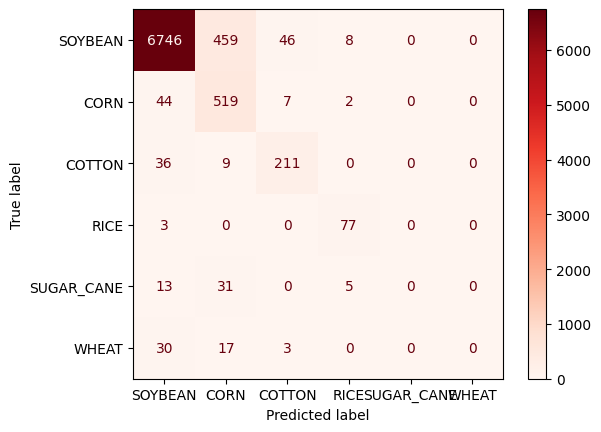

In [ ]:
# Define the true labels and predicted labels
true_labels = eval_gdf_crop_not_null['gt_class']
predicted_labels = eval_gdf_crop_not_null['crop_class_rnn']

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=eval_gdf_crop_not_null['gt_class'].unique())

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eval_gdf_crop_not_null['gt_class'].unique())
disp.plot(cmap="Reds")
plt.show()

In [28]:
eval_gdf_crop_not_null["crop_score_rnn"] = pd.to_numeric(eval_gdf_crop_not_null["crop_score_rnn"])

/home/ec2-user/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
eval_gdf_crop_not_null.period.unique()

first_season = ['2023/2024', '2021/2022', '2020/2021', '2017/2018', '2018/2019',
       '2019/2020', '2022/2023']

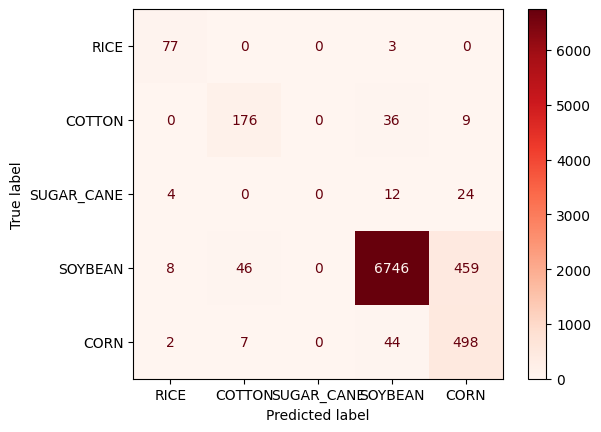

In [30]:
score_gdf_1_season = eval_gdf_crop_not_null[(eval_gdf_crop_not_null.crop_score_rnn >= 0) & (eval_gdf_crop_not_null.period.isin(first_season))]
# Define the true labels and predicted labels
true_labels = score_gdf_1_season['gt_class']
predicted_labels = score_gdf_1_season['crop_class_rnn']

labels = list(set(np.concatenate((score_gdf_1_season['gt_class'].unique(), score_gdf_1_season['crop_class_rnn'].unique())).tolist()))

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Reds")
plt.show()

In [31]:
score_gdf_1_season[(score_gdf_1_season.gt_class == "SOYBEAN") & (score_gdf_1_season.crop_class_rnn == "CORN")][["state"]].value_counts()

state
SP       104
MT        96
MS        77
PR        61
PA        45
GO        19
PI        14
BA         9
TO         9
MA         7
RS         7
MG         6
RO         5
dtype: int64

/home/ec2-user/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='crop_score_rnn', ylabel='Percent'>

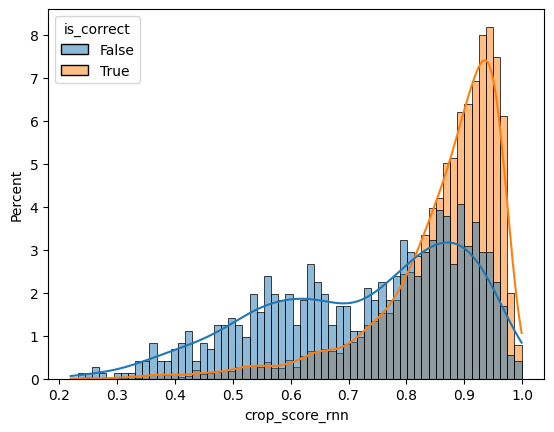

In [32]:
eval_gdf_crop_not_null["is_correct"] = eval_gdf_crop_not_null.gt_class == eval_gdf_crop_not_null.crop_class_rnn
sns.histplot(data=eval_gdf_crop_not_null, x="crop_score_rnn", hue="is_correct", kde=True, stat="percent", common_norm=False)

<Axes: xlabel='crop_score_rnn', ylabel='Percent'>

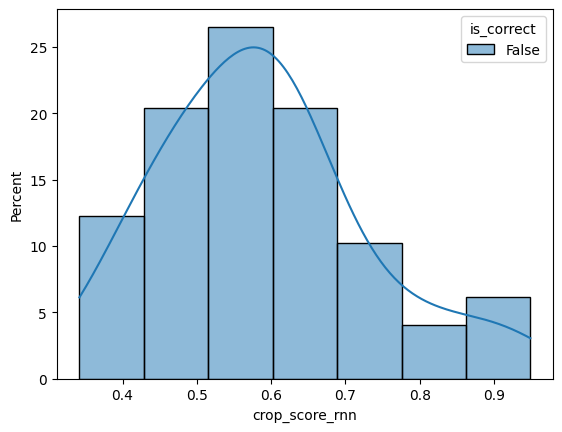

In [92]:
sns.histplot(data=eval_gdf_crop_not_null[eval_gdf_crop_not_null.gt_class == "SUGAR_CANE"], 
            x="crop_score_rnn", hue="is_correct", kde=True, stat="percent", common_norm=False)

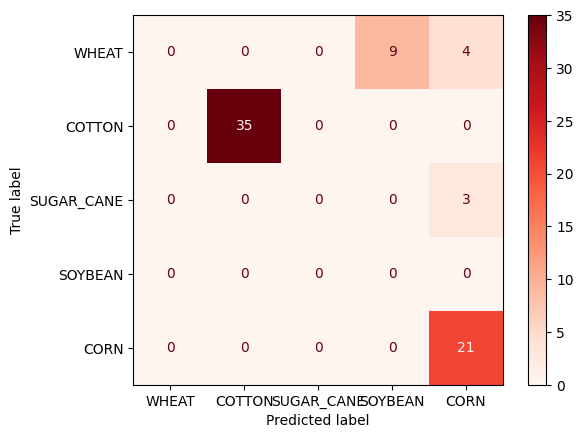

In [33]:
score_gdf_2_season = eval_gdf_crop_not_null[(eval_gdf_crop_not_null.crop_score_rnn > 0.6) & (~eval_gdf_crop_not_null.period.isin(first_season))]
# Define the true labels and predicted labels
true_labels = score_gdf_2_season['gt_class']
predicted_labels = score_gdf_2_season['crop_class_rnn']

labels = list(set(np.concatenate((score_gdf_2_season['gt_class'].unique(), score_gdf_2_season['crop_class_rnn'].unique())).tolist()))

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Reds")
plt.show()

In [34]:
# find the main confusions with soybean (omission) for CROP
soybean_confusion = eval_gdf_crop_not_null[(eval_gdf_crop_not_null['gt_class'] == 'SOYBEAN') & (eval_gdf_crop_not_null['crop_class_rnn'] != 'SOYBEAN')]
soybean_confusion.crop_class_rnn.value_counts()

CORN      459
COTTON     46
RICE        8
Name: crop_class_rnn, dtype: int64

In [35]:
# find the main confusions with soybean (inclusion) for CROP
soybean_confusion = eval_gdf_crop_not_null[(eval_gdf_crop_not_null['gt_class'] != 'SOYBEAN') & (eval_gdf_crop_not_null['crop_class_rnn'] == 'SOYBEAN')]
soybean_confusion.gt_class.value_counts()

CORN          44
COTTON        36
WHEAT         30
SUGAR_CANE    13
RICE           3
Name: gt_class, dtype: int64

In [36]:
# find the main confusions with soybean (omission) for SITS
soybean_confusion = eval_gdf[(eval_gdf['gt_class'] == 'SOYBEAN') & (eval_gdf['crop_class_sits'] != 'SOYBEAN')]
soybean_confusion.crop_class_sits.value_counts()

CORN          938
COTTON        137
RICE            7
SUGAR_CANE      5
Name: crop_class_sits, dtype: int64

In [37]:
# find the main confusions with soybean (inclusion) for SITS
soybean_confusion = eval_gdf[(eval_gdf['gt_class'] != 'SOYBEAN') & (eval_gdf['crop_class_sits'] == 'SOYBEAN')]
soybean_confusion.gt_class.value_counts()

COTTON    51
CORN      32
Name: gt_class, dtype: int64

## Taxas de omissão e taxas de inclusão

In [38]:
def bootstrap_sample(eval_gdf, target_class='SOYBEAN', target_ratio=0.5):
    # Separate the target class and other classes
    target_samples = eval_gdf[eval_gdf['gt_class'] == target_class]
    other_samples = eval_gdf[eval_gdf['gt_class'] != target_class]
    
    # Calculate the number of target samples to select
    num_target_samples = int(len(eval_gdf) * target_ratio)
    
    # Perform bootstrapping
    target_bootstrap = target_samples.sample(n=num_target_samples, replace=True)
    other_bootstrap = other_samples.sample(n=len(eval_gdf) - num_target_samples, replace=True)
    
    # Combine the bootstrapped samples
    bootstrap_gdf = pd.concat([target_bootstrap, other_bootstrap])
    
    return bootstrap_gdf

In [39]:
# example
bootstrap_gdf = bootstrap_sample(eval_gdf_crop_not_null, target_class='SOYBEAN', target_ratio=0.7)
value_counts_percentage = bootstrap_gdf.gt_class.value_counts() / len(bootstrap_gdf) * 100
value_counts_percentage   

SOYBEAN       69.997580
CORN          16.586015
COTTON         8.153883
RICE           2.068715
WHEAT          1.705783
SUGAR_CANE     1.488023
Name: gt_class, dtype: float64

In [40]:
def run_experiment(eval_gdf, n=1000, target_class='SOYBEAN', target_ratio=0.5, pred_column='crop_class_rnn', gt_column='gt_class'):
    inclusion_lst = []
    omission_lst = []
    
    for _ in tqdm(range(n), total=n):
        bootstrap_gdf = bootstrap_sample(eval_gdf, target_class, target_ratio)
 
        # calculate inclusion mistakes
        inclusion_mistakes = bootstrap_gdf[((bootstrap_gdf[pred_column] == target_class) & (bootstrap_gdf[gt_column] != target_class))]
        inclusion_mistake_ratio = len(inclusion_mistakes) / len(bootstrap_gdf[bootstrap_gdf['gt_class'] == target_class])
        inclusion_lst.append(inclusion_mistake_ratio)

        # calculate omission mistakes
        omission_mistakes = bootstrap_gdf[((bootstrap_gdf[pred_column] != target_class) & (bootstrap_gdf[gt_column] == target_class))]
        omission_mistake_ratio = len(omission_mistakes) / len(bootstrap_gdf[bootstrap_gdf['gt_class'] == target_class])
        omission_lst.append(omission_mistake_ratio)
        
    return inclusion_lst, omission_lst

In [41]:
# TODO: we can test for multiple target_ratios!
inc_lst, omss_lst = run_experiment(eval_gdf_crop_not_null, n=100, target_class='SOYBEAN', target_ratio=0.7)

100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


In [42]:
np.array(inc_lst).mean(), np.array(omss_lst).mean()

(0.05333218112685793, 0.07079675077773938)

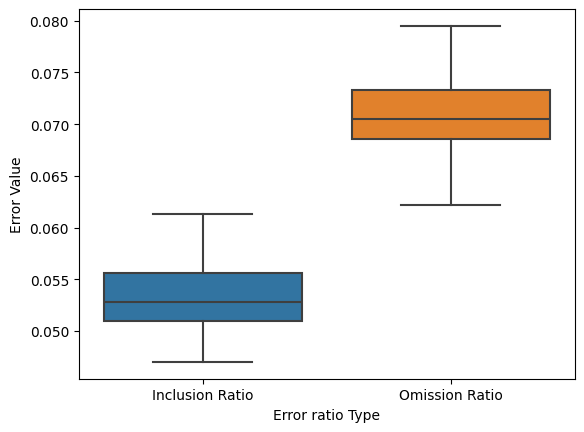

In [43]:
# Create a dataframe with the data
data = {'Inclusion Ratio': inc_lst, 'Omission Ratio': omss_lst}
df = pd.DataFrame(data)

# Plot the boxplot
sns.boxplot(data=df)

# Set the labels and title
plt.xlabel('Error ratio Type')
plt.ylabel('Error Value')

# Show the plot
plt.show()

### This is just a test to understand better the ratio functions

In [44]:
# example
bootstrap_gdf = bootstrap_sample(eval_gdf_crop_not_null, target_class='SOYBEAN', target_ratio=0.7)
value_counts_percentage = bootstrap_gdf.gt_class.value_counts() / len(bootstrap_gdf) * 100
value_counts_percentage   

SOYBEAN       69.997580
CORN          16.961045
COTTON         8.045004
RICE           2.395354
WHEAT          1.342850
SUGAR_CANE     1.258166
Name: gt_class, dtype: float64

In [45]:
pred_column='crop_class_rnn'; gt_column='gt_class'; target_class="SOYBEAN"

In [46]:
# inclusion
inclusion_mistakes = bootstrap_gdf[((bootstrap_gdf[pred_column] == target_class) & (bootstrap_gdf[gt_column] != target_class))]
inclusion_mistake_ratio = len(inclusion_mistakes) / len(bootstrap_gdf[bootstrap_gdf['gt_class'] == target_class])
inclusion_mistake_ratio
# this means that for each 1 sample of soybean, the model is making 0.07 mistakes of inclusion of other classes
# for example, for 9143 samples of soybean, the model is making 650 mistakes of inclusion of other classes

0.053231939163498096

In [47]:
# omission
omission_mistakes = bootstrap_gdf[((bootstrap_gdf[pred_column] != target_class) & (bootstrap_gdf[gt_column] == target_class))]
omission_mistake_ratio = len(omission_mistakes) / len(bootstrap_gdf[bootstrap_gdf['gt_class'] == target_class])
omission_mistake_ratio
# this means that for each 1 sample of soybean, the model is making 0.091 mistakes of omission
# for example, for 9143 samples of soybean, we will expect 9143 * 0.091 = 831 mistakes of omission

0.07189768406498445

## Score threshold analysis

In [48]:
def evaluate_thresholds(gdf: gpd.GeoDataFrame, score_column: str = 'crop_score_rnn', thresholds: np.ndarray = np.arange(0.05, 0.95, 0.05)) -> List[Dict[str, Any]]:
    """
    Evaluate different thresholds for a given score column in a GeoDataFrame.
    
    Parameters:
        gdf (GeoDataFrame): The input GeoDataFrame containing the data to be evaluated.
        score_column (str): The name of the column containing the scores to be evaluated. Default is 'crop_score_rnn'.
        thresholds (np.ndarray): An array-like object containing the thresholds to be evaluated. Default is np.arange(0.05, 0.95, 0.05).
    
    Returns:
        List[Dict[str, Any]]: A list of dictionaries, where each dictionary contains the following information for a specific threshold:
            - 'threshold' (float): The threshold value.
            - 'inclusion_errors' (Dict[str, float]): The inclusion errors calculated for the filtered data.
            - 'omission_errors' (Dict[str, float]): The omission errors calculated for the filtered data.
            - 'percentage_samples' (float): The percentage of samples inside the filtered data.
    """
    results = []

    if not gdf[score_column].dtype == float:
        gdf[score_column] = gdf[score_column].astype(float)

    for threshold in thresholds:
        # Filter samples based on the threshold
        filtered_gdf = gdf[gdf[score_column] > threshold]
        
        # Calculate omission and inclusion errors
        inclusion_errors = calculate_inclusion_error_multiclass(filtered_gdf)
        omission_errors = calculate_omission_error_multiclass(filtered_gdf)
        
        # Calculate the percentage of samples inside the filtered gdf
        percentage_samples = len(filtered_gdf) / len(gdf) * 100
        
        # Store the results
        results.append({
            'threshold': threshold,
            'inclusion_errors': inclusion_errors,
            'omission_errors': omission_errors,
            'percentage_samples': percentage_samples
        })
    
    return results

In [49]:
res = evaluate_thresholds(eval_gdf_crop_not_null, score_column='crop_score_rnn')
df = pd.json_normalize(res, sep='_')
df

threshold  percentage_samples  inclusion_errors_WHEAT  \
0        0.05          100.000000                     0.0   
1        0.10          100.000000                     0.0   
2        0.15          100.000000                     0.0   
3        0.20          100.000000                     0.0   
4        0.25           99.951609                     0.0   
5        0.30           99.866925                     0.0   
6        0.35           99.612872                     0.0   
7        0.40           99.116864                     0.0   
8        0.45           98.390999                     0.0   
9        0.50           97.447375                     0.0   
10       0.55           95.850472                     0.0   
11       0.60           94.084200                     0.0   
12       0.65           91.446891                     0.0   
13       0.70           88.386160                     0.0   
14       0.75           83.776917                     0.0   
15       0.80           76.639245                     0.0   
16       0.85           63.755142                     NaN   
17       0.90           43.467215                     NaN   

    inclusion_errors_RICE  inclusion_errors_COTTON  \
0                0.163043                 0.209738   
1                0.163043                 0.209738   
2                0.163043                 0.209738   
3                0.163043                 0.209738   
4                0.153846                 0.209738   
5                0.134831                 0.209738   
6                0.134831                 0.206767   
7                0.126437                 0.201521   
8                0.096386                 0.193050   
9                0.050633                 0.183594   
10               0.038462                 0.171315   
11               0.013158                 0.165992   
12               0.013158                 0.160494   
13               0.000000                 0.157447   
14               0.000000                 0.159292   
15               0.000000                 0.144186   
16               0.000000                 0.140000   
17               0.000000                 0.136126   

    inclusion_errors_SUGAR_CANE  inclusion_errors_SOYBEAN  \
0                             0                  0.018335   
1                             0                  0.018335   
2                             0                  0.018335   
3                             0                  0.018335   
4                             0                  0.018198   
5                             0                  0.018063   
6                             0                  0.017377   
7                             0                  0.017153   
8                             0                  0.015777   
9                             0                  0.014706   
10                            0                  0.012797   
11                            0                  0.009937   
12                            0                  0.007516   
13                            0                  0.006135   
14                            0                  0.005435   
15                            0                  0.004793   
16                            0                  0.004617   
17                            0                  0.004521   

    inclusion_errors_CORN  omission_errors_WHEAT  omission_errors_RICE  \
0                0.498551                    1.0              0.037500   
1                0.498551                    1.0              0.037500   
2                0.498551                    1.0              0.037500   
3                0.498551                    1.0              0.037500   
4                0.498551                    1.0              0.037500   
5                0.499033                    1.0              0.037500   
6                0.497575                    1.0              0.037500   
7                0.495108                    1.0              0.0

In [50]:
def plot_errors(df, crop_name="SOYBEAN"):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Bar(
            x=df['threshold'],
            y=df[f'inclusion_errors_{crop_name}'],
            name='Inclusion Errors',
            text=df[f'inclusion_errors_{crop_name}'],
            texttemplate='%{text:.1%}',
            textposition='outside',
            textfont=dict(color='blue')
        ),
        secondary_y=False
    )

    # Create the second subplot with omission errors
    fig.add_trace(
        go.Bar(
            x=df['threshold'],
            y=df[f'omission_errors_{crop_name}'],
            name='Omission Errors',
            text=df[f'omission_errors_{crop_name}'],
            texttemplate='%{text:.1%}',
            textposition='outside',
            textfont=dict(color='red')
        ),
        secondary_y=False
    )

    # Add the line plot for percentage samples
    fig.add_trace(
        go.Scatter(
            x=df['threshold'],
            y=df['percentage_samples'],
            name='Percentage Samples',
            line=dict(color='#8d99ae'),
            mode='lines+markers+text',
            text=df['percentage_samples'],
            texttemplate='%{text:.0f}%',
            textposition='top center',
            textfont=dict(color='grey', size=10)
        ),
        secondary_y=True
    )

    # Set the layout
    fig.update_layout(
        template="plotly",
        title=f'Inclusion and Omission Errors for {crop_name}',
        xaxis_title='Threshold',
        yaxis_title='Error Value',
        yaxis2_title='Percentage Samples',
        yaxis=dict(range=[0, 1])
    )

    # Show the plot
    fig.show()

In [51]:
plot_errors(df, crop_name="SOYBEAN")

In [52]:
plot_errors(df, crop_name="CORN")

In [53]:
plot_errors(df, crop_name="RICE")

In [54]:
plot_errors(df, crop_name="COTTON")

In [55]:
eval_gdf_crop_not_null[(eval_gdf_crop_not_null.gt_class != "COTTON") & \
    (eval_gdf_crop_not_null.crop_score_rnn > 0.8) & \
         (eval_gdf_crop_not_null.crop_class_rnn == "COTTON")].gt_class.value_counts()

SOYBEAN    29
CORN        2
Name: gt_class, dtype: int64

## TAXA de omissão e TAXA de inclusão para diferentes thresholds

### Considerando 70% de soja vs. outras culturas diversas

In [56]:
def run_experiment_taxas(eval_gdf, n=1000, target_class='SOYBEAN', target_ratio=0.5, pred_column='crop_class_rnn', gt_column='gt_class', threshold=0.5):
    inclusion_lst = []
    omission_lst = []
    len_filtered_lst = []
    
    for _ in tqdm(range(n), total=n):
        bootstrap_gdf = bootstrap_sample(eval_gdf, target_class, target_ratio)

        # Filter samples based on the threshold
        filtered_gdf = bootstrap_gdf[bootstrap_gdf["crop_score_rnn"] > threshold]
 
        # calculate inclusion mistakes
        inclusion_mistakes = filtered_gdf[((filtered_gdf[pred_column] == target_class) & (filtered_gdf[gt_column] != target_class))]
        inclusion_mistake_ratio = len(inclusion_mistakes) / len(filtered_gdf[filtered_gdf['gt_class'] == target_class])
        inclusion_lst.append(inclusion_mistake_ratio)

        # calculate omission mistakes
        omission_mistakes = filtered_gdf[((filtered_gdf[pred_column] != target_class) & (filtered_gdf[gt_column] == target_class))]
        omission_mistake_ratio = len(omission_mistakes) / len(filtered_gdf[filtered_gdf['gt_class'] == target_class])
        omission_lst.append(omission_mistake_ratio)

        len_filtered_lst.append(len(filtered_gdf))
        
    return inclusion_lst, omission_lst, len_filtered_lst

In [57]:
thresholds = np.arange(0.05, 0.95, 0.05)

results_taxa = {}
for threshold in thresholds:

    # inc_lst, omss_lst, len_filtered_gdf = run_experiment_taxas(eval_gdf_crop_not_null, n=1000, target_class='SOYBEAN', target_ratio=0.7, threshold=threshold)
    inc_lst, omss_lst, len_filtered_gdf = run_experiment_taxas(eval_gdf_crop_not_null, n=10, target_class='SOYBEAN', target_ratio=0.7, threshold=threshold)

    # Calculate the percentage of samples inside the filtered gdf
    percentage_samples = [x / len(eval_gdf_crop_not_null) * 100 for x in len_filtered_gdf]
    
    # Store the results
    results_taxa[threshold] = {
        'inclusion_errors': inc_lst,
        'omission_errors': omss_lst,
        'percentage_samples': percentage_samples
    }

100%|██████████| 10/10 [00:00<00:00, 13.89it/s]


In [58]:
df_taxas = pd.DataFrame.from_dict(results_taxa, orient='index')

# Calculate the mean of each row in the inclusion_errors column
df_taxas['inclusion_errors_mean'] = df_taxas['inclusion_errors'].apply(lambda x: np.mean(x))

# Calculate the median of each row in the inclusion_errors column
df_taxas['inclusion_errors_median'] = df_taxas['inclusion_errors'].apply(lambda x: np.median(x))

# Calculate the standard deviation of each row in the inclusion_errors column
df_taxas['inclusion_errors_std'] = df_taxas['inclusion_errors'].apply(lambda x: np.std(x))

# Calculate the mean of each row in the omission_errors column
df_taxas['omission_errors_mean'] = df_taxas['omission_errors'].apply(lambda x: np.mean(x))

# Calculate the median of each row in the omission_errors column
df_taxas['omission_errors_median'] = df_taxas['omission_errors'].apply(lambda x: np.median(x))

# Calculate the standard deviation of each row in the omission_errors column
df_taxas['omission_errors_std'] = df_taxas['omission_errors'].apply(lambda x: np.std(x))

# Calculate the mean of each row in the percentage_samples column
df_taxas['percentage_samples_mean'] = df_taxas['percentage_samples'].apply(lambda x: np.mean(x))

# Calculate the median of each row in the percentage_samples column
df_taxas['percentage_samples_median'] = df_taxas['percentage_samples'].apply(lambda x: np.median(x))

# Calculate the standard deviation of each row in the percentage_samples column
df_taxas['percentage_samples_std'] = df_taxas['percentage_samples'].apply(lambda x: np.std(x))

In [59]:
# salvar o df_taxas para nao precisar rodar tudo de novo

In [60]:
# Create the figure
fig = go.Figure()

fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add the bar trace for inclusion errors
fig.add_trace(go.Bar(
    x=df_taxas.index,
    y=df_taxas['inclusion_errors_mean'],
    name='Inclusion Errors',
    text=df_taxas['inclusion_errors_mean'],
    texttemplate='%{text:.1%}',
    textposition='outside',
    textfont=dict(color='blue'),
    error_y=dict(
        type='data',
        array=df_taxas['inclusion_errors_std'],
        visible=True
    )
))

# Add the bar trace for omission errors
fig.add_trace(go.Bar(
    x=df_taxas.index,
    y=df_taxas['omission_errors_mean'],
    name='Omission Errors',
    text=df_taxas['omission_errors_mean'],
    texttemplate='%{text:.1%}',
    textposition='outside',
    textfont=dict(color='red'),
    error_y=dict(
        type='data',
        array=df_taxas['omission_errors_std'],
        visible=True
    )
))

# Add the line trace for percentage samples
fig.add_trace(go.Scatter(
    x=df_taxas.index,
    y=df_taxas['percentage_samples_mean'],
    name='Percentage Samples',
    mode='lines+markers+text',
    line=dict(color='#8d99ae'),
    text=df_taxas['percentage_samples_mean'],
    texttemplate='%{text:.0f}%',
    textposition='top center',
    textfont=dict(color='grey', size=10),
    error_y=dict(
        type='data',
        array=df_taxas['percentage_samples_std'],
        visible=True
    )
),
    secondary_y=True
)

# Set the layout
fig.update_layout(
    title='Mean Inclusion and Omission Errors vs. Percentage of Samples for SOYBEAN',
    xaxis_title='Threshold',
    yaxis_title='Error Value',
    yaxis=dict(range=[0, 1]),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(0,0,0,0)'
    )
)

# Show the plot
fig.show()

## Experimentos com taxas

In [61]:
import sys
sys.path.append("/agrilearn_app/TASKS/crop-class/ALTEDATA-2080-eval-models")

from eval_taxas import run_experiments, plot_results

In [62]:
# comparing only between 2 classes
# eval_gdf_crop_not_null_soy_cotton = eval_gdf_crop_not_null[eval_gdf_crop_not_null.gt_class.isin(['SOYBEAN', 'COTTON']) & \
#      eval_gdf_crop_not_null.crop_class_rnn.isin(['SOYBEAN', 'COTTON'])]

In [63]:
# len(eval_gdf_crop_not_null_soy_cotton)

In [64]:
eval_gdf_crop_not_null.set.unique()

array(['run_2082_mvp_5972_bb_areas_crop_120.gpkg',
       'run_2082_mvp_2045_teste_set_crop_120.gpkg',
       'run_2082_mvp_344_teste_concordancia_crop_120.gpkg'], dtype=object)

In [65]:
# Set the parameters
n = 10
target_class = "SOYBEAN"
target_ratio = 0.7
thresholds = np.arange(0.05, 0.95, 0.05)

# Run the experiments
df_taxas = run_experiments(eval_gdf_crop_not_null[eval_gdf_crop_not_null.period.isin(first_season)], thresholds, n, target_class, target_ratio)

# Plot the results
plot_results(df_taxas, target_class)

 80%|████████  | 8/10 [00:00<00:00, 11.62it/s]

100%|██████████| 10/10 [00:00<00:00, 13.54it/s]


In [66]:
import plotly.graph_objects as go

# Define the confidence level thresholds
low_threshold = 0.4
high_threshold = 0.6

# Create the three buckets based on the confidence level
low_confidence = eval_gdf_crop_not_null[eval_gdf_crop_not_null['crop_score_rnn'] < low_threshold]
medium_confidence = eval_gdf_crop_not_null[(eval_gdf_crop_not_null['crop_score_rnn'] >= low_threshold) & (eval_gdf_crop_not_null['crop_score_rnn'] < high_threshold)]
high_confidence = eval_gdf_crop_not_null[eval_gdf_crop_not_null['crop_score_rnn'] >= high_threshold]

# Count the correct and incorrect classes in each bucket
low_correct_count = len(low_confidence[low_confidence['gt_class'] == low_confidence['crop_class_rnn']])
low_incorrect_count = len(low_confidence[low_confidence['gt_class'] != low_confidence['crop_class_rnn']])

medium_correct_count = len(medium_confidence[medium_confidence['gt_class'] == medium_confidence['crop_class_rnn']])
medium_incorrect_count = len(medium_confidence[medium_confidence['gt_class'] != medium_confidence['crop_class_rnn']])

high_correct_count = len(high_confidence[high_confidence['gt_class'] == high_confidence['crop_class_rnn']])
high_incorrect_count = len(high_confidence[high_confidence['gt_class'] != high_confidence['crop_class_rnn']])

# Create the bar plot
fig = go.Figure(data=[
    go.Bar(name='Correct', x=['Low Confidence', 'Medium Confidence', 'High Confidence'], 
        y=[low_correct_count/len(eval_gdf_crop_not_null)*100, medium_correct_count/len(eval_gdf_crop_not_null)*100, high_correct_count/len(eval_gdf_crop_not_null)*100]),
    go.Bar(name='Incorrect', x=['Low Confidence', 'Medium Confidence', 'High Confidence'],
        y=[low_incorrect_count/len(eval_gdf_crop_not_null)*100, medium_incorrect_count/len(eval_gdf_crop_not_null)*100, high_incorrect_count/len(eval_gdf_crop_not_null)*100])
])

# Update the layout
fig.update_layout(
    title='Correct vs Incorrect Classes by Confidence Level',
    xaxis_title='Confidence Level',
    yaxis_title='Percentage',
    barmode='group'
)


# Show the plot
fig.show()

In [86]:
# Filter for the first season and high confidence
first_season_high_confidence = eval_gdf_crop_not_null[
    (eval_gdf_crop_not_null['period'].isin(first_season)) & 
    (eval_gdf_crop_not_null['crop_score_rnn'] >= 0) &
    (eval_gdf_crop_not_null['crop_score_rnn'] < 0.4)
]

# Calculate inclusion error (false positives)
inclusion_error_count = len(first_season_high_confidence[first_season_high_confidence['gt_class'] != first_season_high_confidence['crop_class_rnn']])

# Calculate omission error (false negatives)
omission_error_count = len(first_season_high_confidence[first_season_high_confidence['gt_class'] == first_season_high_confidence['crop_class_rnn']])

# Print the results
print(f"Inclusion Error Count: {inclusion_error_count}")
print(f"Omission Error Count: {omission_error_count}")

Inclusion Error Count: 21
Omission Error Count: 47


In [67]:
len(eval_gdf_crop_not_null[eval_gdf_crop_not_null.crop_score_rnn > 0.6])/len(eval_gdf_crop_not_null)

0.9408420033873699

In [81]:
# Set the parameters
n = 10
target_class = "CORN"
target_ratio = 0.1
thresholds = np.arange(0.05, 0.95, 0.05)

# Run the experiments
df_taxas = run_experiments(eval_gdf_crop_not_null, thresholds, n, target_class, target_ratio)

# Plot the results
plot_results(df_taxas, target_class)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 15.20it/s]


In [69]:
eval_gdf_crop_not_null[(eval_gdf_crop_not_null.gt_class == "SOYBEAN") & \
    (eval_gdf_crop_not_null.crop_score_rnn > 0.9) & \
         (eval_gdf_crop_not_null.crop_class_rnn != "SOYBEAN")]["crop_class_rnn"].value_counts()

CORN      82
COTTON    25
Name: crop_class_rnn, dtype: int64

In [70]:
eval_gdf_crop_not_null[(eval_gdf_crop_not_null.gt_class == "COTTON") & \
    (eval_gdf_crop_not_null.crop_score_rnn > 0.8) & \
         (eval_gdf_crop_not_null.crop_class_rnn != "COTTON")]["crop_class_rnn"].value_counts()
# checar alguns casos dos dados da lapig

SOYBEAN    6
CORN       2
Name: crop_class_rnn, dtype: int64

In [71]:
eval_gdf_crop_not_null[(eval_gdf_crop_not_null.gt_class == "COTTON") & \
    (eval_gdf_crop_not_null.crop_score_rnn > 0.8) & \
         (eval_gdf_crop_not_null.crop_class_rnn != "COTTON")].to_file("errors_lapig_cotton_score_08.gpkg")

In [72]:
# quais as principais confusoes com soja mesmo?
# dessas confusões, avaliar o score
# separar se tem problemas com diferentes safras
# classification report para todos os dados (aqui incluimos nulo como STRING- como uma classe)
# trazer o % de nulos e as razoes
# para apresentar, colocar do lado do plot a distribuicao das classes? mas no caso do bootstrapping, a distribuicao muda

# alguns erros de inclusao que estao dando score alto no crop!
# filtrar dataset de cana para as 2 avaliacoes

# BR Map

In [73]:
# Load the GeoPackage file containing geometries of Brazilian states
states_gdf = gpd.read_file('/agrilearn_app/TASKS/crop-class/ALTEDATA-2080-eval-models/data/BR_UF_2021/BR_UF_2021.shp')

In [74]:
def calculate_info_by_uf(states_gdf: gpd.GeoDataFrame, eval_gdf_crop_not_null: gpd.GeoDataFrame) -> typing.Dict[str, typing.Dict[str, typing.Any]]:
    info_by_uf = {}
    for idx, uf in tqdm(states_gdf.iterrows(), total=len(states_gdf)):
        crops_within_state = eval_gdf_crop_not_null[eval_gdf_crop_not_null.geometry.within(uf.geometry)]
        inc_errors = calculate_inclusion_error_multiclass(crops_within_state)
        oms_erros = calculate_omission_error_multiclass(crops_within_state)

        centroid = uf.geometry.centroid
        class_counts = crops_within_state['gt_class'].value_counts().to_dict()  # Get the count of each class

        info_by_uf[uf['SIGLA']] = {
            'inclusion_errors': inc_errors,
            'omission_errors': oms_erros,
            'centroid_x': centroid.x,
            'centroid_y': centroid.y,
            'class_counts': class_counts  # Save the count of each class
        }

    # Assuming info_by_uf is already defined and contains the data
    df = pd.DataFrame.from_dict(info_by_uf, orient="index")

    # Normalize the DataFrame to flatten the dictionaries into new columns
    normalized_df = pd.json_normalize(df.to_dict(orient='records'), sep='_')

    # If you need to keep the original index, you can reset it and merge it back
    normalized_df.index = df.index
    
    return normalized_df

In [75]:
def plot_erro_inclusao_omissao_count(erro_inclusao_df, shapefile_path, crop_name):

    # Carregar o shapefile dos estados do Brasil
    brasil = gpd.read_file(shapefile_path)

    # Mesclar os dados de erro de inclusão com os dados geoespaciais
    brasil = brasil.merge(erro_inclusao_df, left_on='SIGLA', right_on='SIGLA').to_crs("EPSG:3857")

    # Plotar o mapa cloropleth
    fig, ax = plt.subplots(1, 3, figsize=(18, 10))  # Modify the figsize to accommodate the third subplot
    brasil.boundary.plot(ax=ax[0], color='black', linewidth=0.5)
    brasil.plot(column=f'inclusion_errors_{crop_name}', ax=ax[0], legend=True, cmap="Reds",
                legend_kwds={'label': "Inclusion error", 
                             'orientation': "horizontal"}, vmin=0, vmax=1)
    brasil.boundary.plot(ax=ax[1], color='black', linewidth=0.5)
    brasil.plot(column=f'omission_errors_{crop_name}', ax=ax[1], legend=True, cmap="Oranges",
                legend_kwds={'label': "Omission error", 
                             'orientation': "horizontal"}, vmin=0, vmax=1)
    
    # Plot the count number of samples for each state
    brasil.boundary.plot(ax=ax[2], color='black', linewidth=0.5)
    brasil.plot(column=f'class_counts_{crop_name}', ax=ax[2], legend=True, cmap="Greens",
                legend_kwds={'label': "Sample Count", 
                             'orientation': "horizontal"})

    # Adicionar rótulos com o valor do erro de inclusão em cada estado
    for x, y, label, uf in zip(brasil.geometry.centroid.x, brasil.geometry.centroid.y, brasil[f'inclusion_errors_{crop_name}'], brasil["SIGLA"]):
        if not pd.isnull(label):
            ax[0].text(x, y, f'{uf} \n {label:.2%}', fontsize=8, ha='center', va='center')

    # Adicionar rótulos com o valor do erro de omissão em cada estado
    for x, y, label, uf in zip(brasil.geometry.centroid.x, brasil.geometry.centroid.y, brasil[f'omission_errors_{crop_name}'], brasil["SIGLA"]):
        if not pd.isnull(label):
            ax[1].text(x, y, f'{uf} \n {label:.2%}', fontsize=8, ha='center', va='center')
    
    # Adicionar rótulos com o número de amostras em cada estado
    for x, y, label, uf in zip(brasil.geometry.centroid.x, brasil.geometry.centroid.y, brasil[f'class_counts_{crop_name}'], brasil["SIGLA"]):
        if not pd.isnull(label):
            ax[2].text(x, y, f'{uf} \n {int(label)}', fontsize=8, ha='center', va='center')

    plt.suptitle(f'Inclusion, omissions errors, and sample count by state // {crop_name}')
    plt.tight_layout()
    plt.show()



 22%|██▏       | 6/27 [00:01<00:06,  3.31it/s]

100%|██████████| 27/27 [01:58<00:00,  4.37s/it]


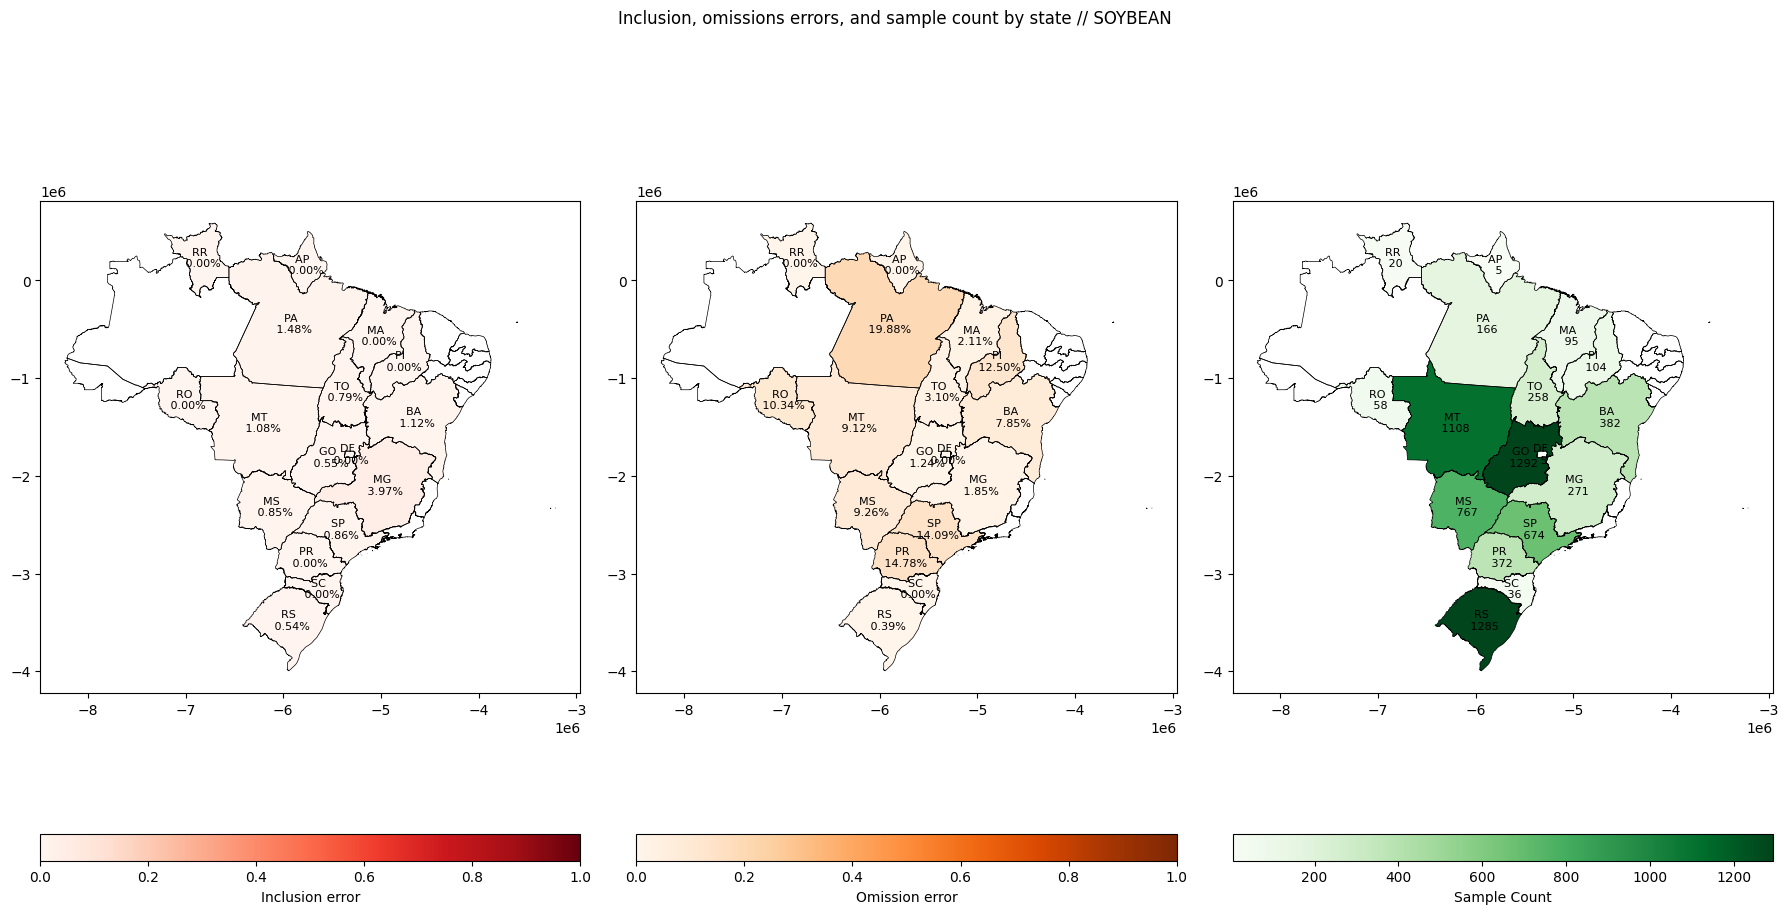

In [94]:
# DataFrame de exemplo com os dados de erro de inclusão por UF
# data = {
#     'SIGLA': ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO'],
#     'ErroInclusao': [5.1, 4.3, 6.2, 3.8, 7.1, 5.5, 2.9, 4.7, 5.0, 6.3, 4.8, 5.6, 6.0, 5.2, 4.4, 5.7, 4.9, 5.3, 4.6, 4.1, 5.8, 3.9, 5.4, 4.5, 4.2, 6.1, 5.9]
# }
# erro_inclusao_df = pd.DataFrame(data)
eval_gdf_crop_not_null_1st_season = eval_gdf_crop_not_null[(eval_gdf_crop_not_null.period.isin(first_season))]

# eval_gdf_crop_not_null_1st_season = eval_gdf_crop_not_null[(eval_gdf_crop_not_null.period.isin(first_season)) &
#                                                                 (eval_gdf_crop_not_null.crop_score_rnn >= 0.6)]


normalized_df = calculate_info_by_uf(states_gdf, eval_gdf_crop_not_null_1st_season)

errors_df = normalized_df.reset_index(names="SIGLA")

# Caminho para o shapefile dos estados do Brasil
shapefile_path = '/agrilearn_app/TASKS/crop-class/ALTEDATA-2080-eval-models/data/BR_UF_2021/BR_UF_2021.shp'

# Chamar a função para plotar o mapa
plot_erro_inclusao_omissao_count(errors_df, shapefile_path, crop_name="SOYBEAN")

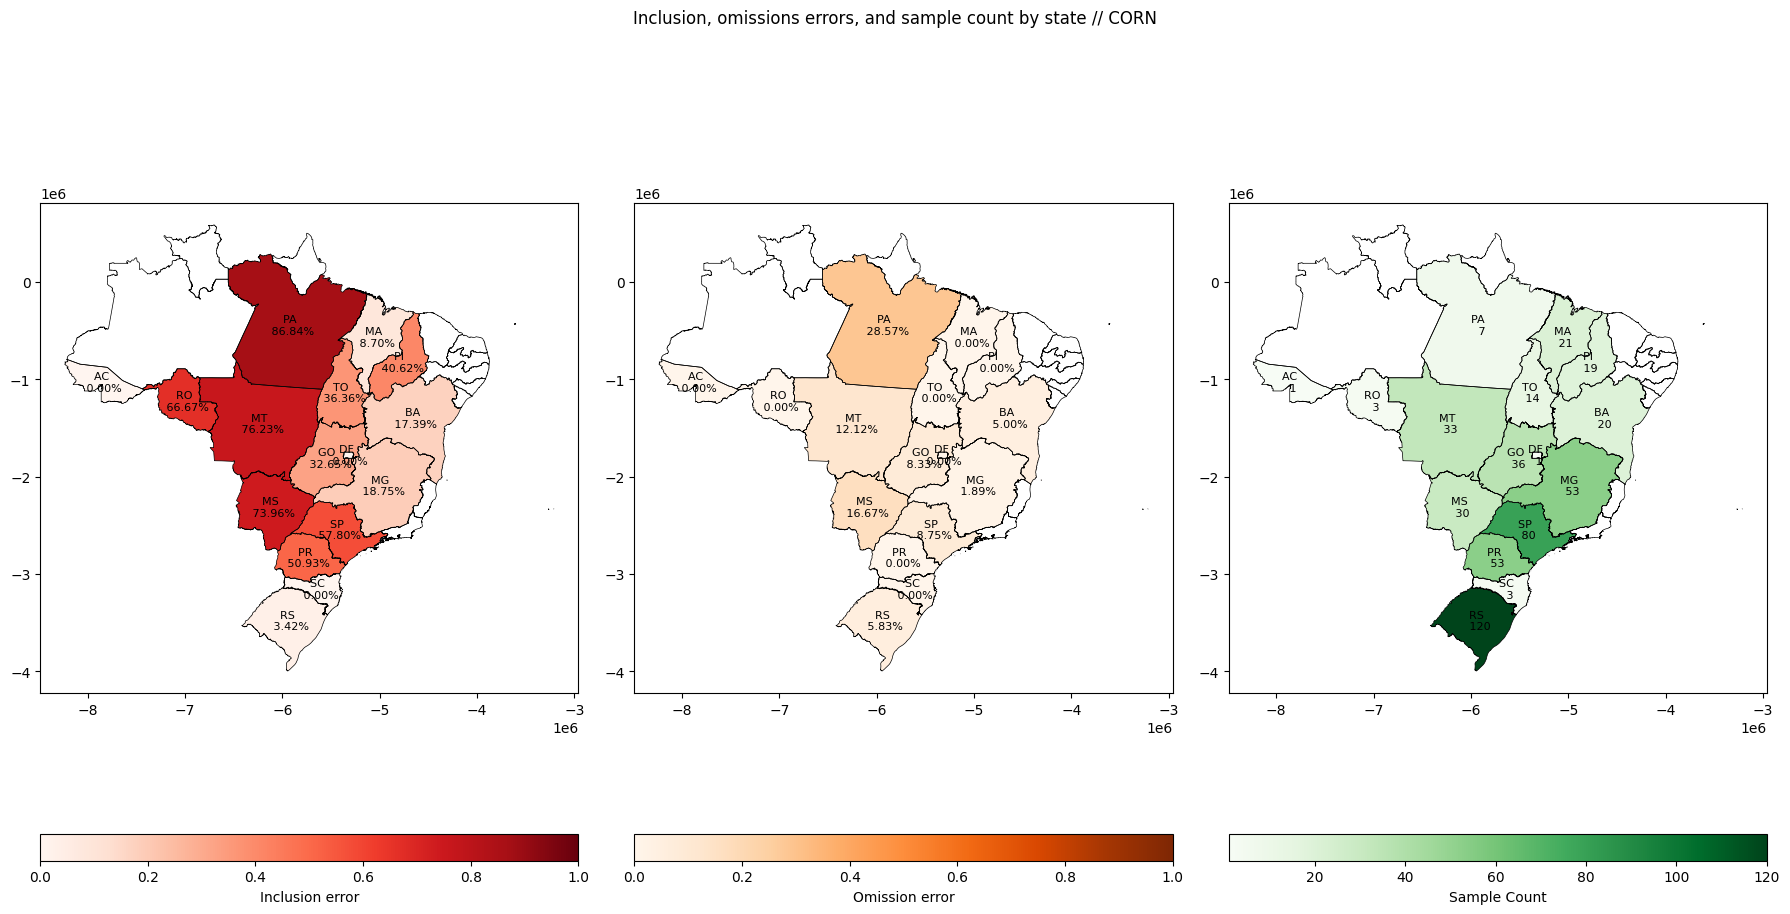

In [95]:
plot_erro_inclusao_omissao_count(errors_df, shapefile_path, crop_name="CORN")

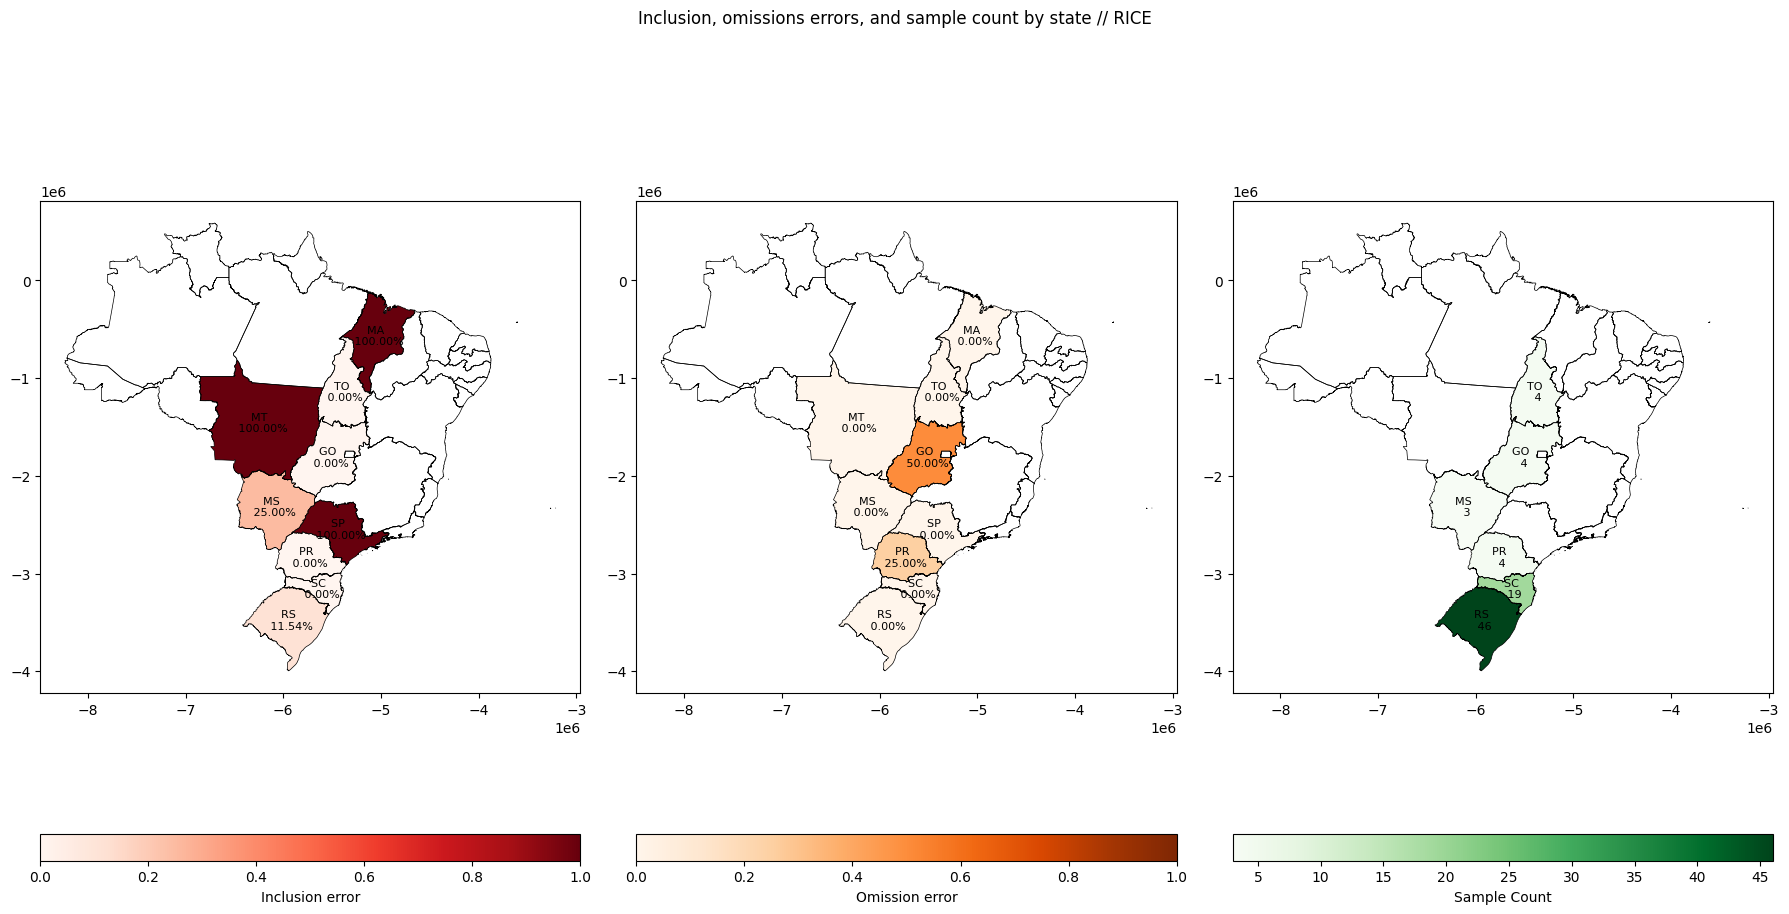

In [78]:
plot_erro_inclusao_omissao_count(errors_df, shapefile_path, crop_name="RICE")

In [79]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get the list of crops
your_list = errors_df.columns[errors_df.columns.str.startswith('class_counts_')]
crops = [item.split("_")[-1] for item in your_list]
crops.remove('CANE')
crops.append('SUGAR_CANE')

# Create subplots: one for each crop
fig = make_subplots(rows=len(crops), cols=1, subplot_titles=[f'Count of {crop}' for crop in crops])

# Add each crop's bar plot to the subplots
for i, crop in enumerate(crops):
    column_name = f'class_counts_{crop}'
    fig.add_trace(
        go.Bar(x=errors_df['SIGLA'], y=errors_df[column_name], name=crop),
        row=i+1, col=1
    )

# Update layout
fig.update_layout(
    height=300*len(crops),  # Adjust height based on number of crops
    showlegend=False,
    title_text="Count of each crop for each state"
)

# Update x-axis labels for all subplots
for i in range(len(crops)):
    fig.update_xaxes(title_text="State", row=i+1, col=1)
    fig.update_yaxes(title_text="Count", row=i+1, col=1)

fig.show()

In [96]:
eval_gdf_crop_not_null_1st_season = eval_gdf_crop_not_null[(eval_gdf_crop_not_null.period.isin(first_season))]

In [98]:
# eval_gdf_crop_not_null_1st_season[(eval_gdf_crop_not_null_1st_season.crop_class_rnn == "CORN") & \
    # (eval_gdf_crop_not_null_1st_season.gt_class == "SOYBEAN")].to_file("/agrilearn_app/TASKS/crop-class/ALTEDATA-2080-eval-models/errors_soybean_corn_crop_rnn120.gpkg")